# Phân vùng ngữ nghĩa trên ảnh
Tổng quan: Ở bài tập này chúng ta sẽ thực hành bài Phân vùng ngữ nghĩa trên hình ảnh sử dụng Mean Shift và FCNs.

Yêu cầu:

Ngôn ngữ lập trình Python 3
Các thư viện cần cài đặt: numpy, tensorflow, opencv.

Để thuận tiện trong việc thực thi, code mẫu được viết để chạy dựa trên Google Colab
Đường dẫn của các thư mục liên quan cần được đặt vào thư mục "Colab Notebooks" trong Google Drive tương ứng (để đọc ảnh gốc cũng như ghi kết quả)


In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from sklearn.cluster import MeanShift
from tqdm import tqdm
import datetime
import scipy.misc
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
from IPython.display import Image
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

#Thiết lập kết nối với Google Drive
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
colab_notebooks_path = "gdrive/MyDrive/Colab Notebooks/"
sys.path.append(colab_notebooks_path)

#Thay đổi thư mục làm việc về thư mục của Colab trên Google Drive
colab_notebooks_path2 = "/content/gdrive/MyDrive/Colab Notebooks/"
os.chdir(colab_notebooks_path2)

Mounted at /content/gdrive/


In [62]:
from tensorflow.keras import callbacks

In [51]:
%cd /content/gdrive/MyDrive/ComputerVision/CV10.SemanticSegmentation

/content/gdrive/MyDrive/ComputerVision/CV10. Semantic Segmentation


## I. Phân vùng ảnh với Mean Shift
Thư viện sklearn cung cấp hàm để thực hiện thuật toán Mean Shift: sklearn.cluster.MeanShift

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html

### Câu hỏi 1: Phân vùng ảnh xám
Ở phần này ta sẽ biểu diễn các mỗi điểm ảnh bằng một vecto 1 chiều (không gian đặc trưng 1D): giá trị độ sáng tại điểm ảnh tương ứng

(183, 275, 3)
(183, 275)
(50325, 1)


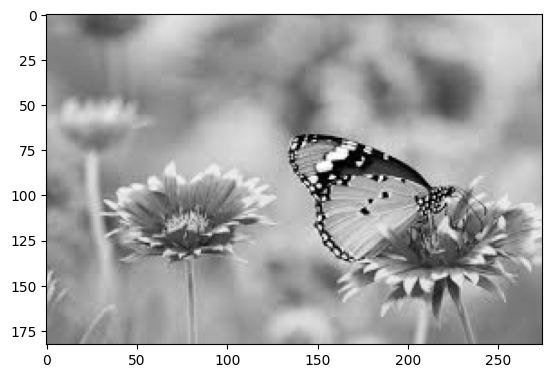

In [12]:
#Image('./jupyter_img/img1.jpg')
img = cv2.imread('./jupyter_img/img1.jpg')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
X = img.reshape((-1, 1))
print(X.shape)
plt.imshow(img, cmap='gray')
plt.show()

Đối với MeanShift, ta cần một hàm để khởi tạo ngẫu nhiên các hạt seed:

MeanShift(bandwidth=2,
          seeds=array([[155],
       [175],
       [195],
       [229],
       [161],
       [151],
       [252],
       [187],
       [142],
       [147]], dtype=uint8))
[[160.4370434 ]
 [155.50581916]
 [151.48224044]
 [147.54462009]
 [174.4873817 ]
 [141.47689857]
 [194.48689956]
 [187.56869369]
 [228.45643154]
 [252.54285714]]
(50325,)


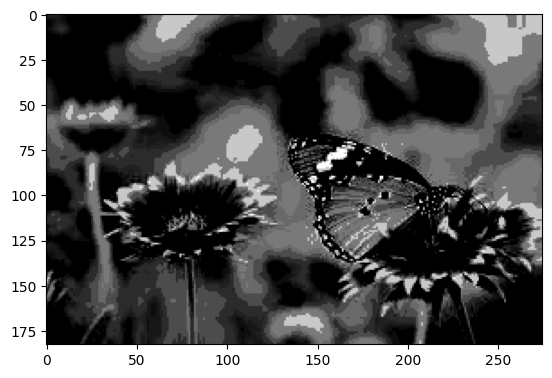

In [13]:
def init_seed(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]

random_seeds = init_seed(X, 10)

###1 YOUR CODE HERE###
ms = MeanShift(bandwidth=2, seeds = random_seeds)
#ms = ???
###END YOUR CODE###
print(ms)
###2 YOUR CODE HERE###
ms.fit(X)
#train ms with data X
###END YOUR CODE###
center = ms.cluster_centers_
label = ms.labels_

print(center)
print(label.shape)

segmented_image = center[label]
segmented_image = np.reshape(segmented_image, img.shape)
# plt.subplots(1, 1, figsize=(12,9))
plt.imshow(segmented_image/255.0, cmap='gray')
plt.show()

### Câu hỏi 2: Phân vùng ảnh màu (RGB)

#### Câu hỏi 2.1: Sử dụng không gian đặc trưng 3D

Trong câu hỏi 2.1, mỗi điểm ảnh sẽ được biểu diễn bởi một vector 3 chiều (thay vì 1 chiều như câu hỏi 1) tương ứng là giá trị màu R, G, B tại điểm ảnh tương ứng. Ta sẽ sử dụng lại ảnh màu ở câu hỏi 1:

(183, 275, 3)


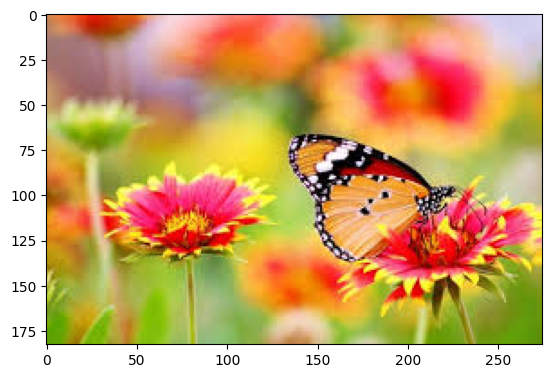

In [14]:
img = plt.imread('./jupyter_img/img1.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

(50325, 3)
MeanShift(bandwidth=2,
          seeds=array([[240, 143,  13],
       [151,  14,   0],
       [225, 127,  18],
       [239, 171,  96],
       [175, 135,  37],
       [165, 197,  70],
       [214, 123,  30],
       [252, 221, 105],
       [168, 173,  71],
       [122, 147,   4],
       [247, 222,  33],
       [254, 175, 178],
       [246, 237,  12],
       [173, 185, 103],
       [245, 219, 222],
       [142, 178,  80],
       [225, 201, 223],
       [245,   0,  22],
       [224, 173,  48],
       [245,  37, 115],
       [142, 168,  43],
       [233,  59,  22],
       [155, 145,  50],
       [159, 108, 104],
       [172, 191, 110],
       [215, 180,  38],
       [162, 173,  55],
       [255, 252,  91],
       [252, 207, 106],
       [147, 192,  65]], dtype=uint8))
30


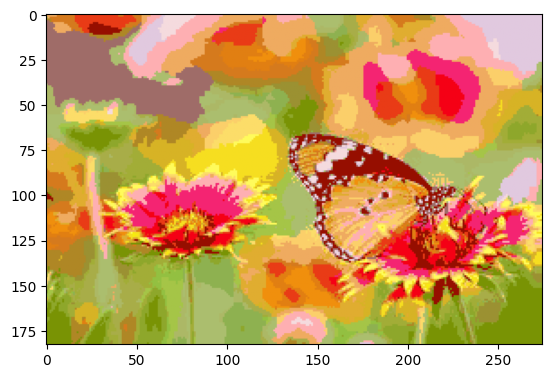

In [15]:
X = img.reshape((-1, 3))
print(X.shape)
random_seeds = init_seed(X, 30)

###3 YOUR CODE HERE###
ms = MeanShift(bandwidth=2, seeds=random_seeds)
print(ms)
ms.fit(X)
#ms = ???
###END YOUR CODE###
center = ms.cluster_centers_
label = ms.labels_

print(len(center))

segmented_image = center[label]
segmented_image = np.reshape(segmented_image, img.shape)
plt.imshow(segmented_image/255.0)
plt.show()

#### Câu hỏi 2.2: Sử dụng không gian đặc trưng 5D
Trong câu hỏi 2.2, mỗi điểm ảnh sẽ được biểu diễn bởi một vector 5 chiều (thay vì 3 chiều như câu hỏi 2.1) tương ứng là giá trị màu R, G, B, tọa độ x, tọa độ y tại điểm ảnh tương ứng. Ta sẽ sử dụng lại ảnh màu ở câu hỏi 2.1:

In [16]:
img = plt.imread('./jupyter_img/img1.jpg')
print(img.shape)

(183, 275, 3)


Hãy lập trình hàm get_5D_vector(img) sau đây, nhận vào một ma trận 3 chiều biễu diễn ảnh màu, trả về ma trận X có vai trò như các câu hỏi trước, mỗi hàng của X biểu diễn vecto ứng với điểm ảnh tương ứng, mỗi vector này có dạng (R, G, B, x, y), trong đó (R, G, B) là cường độ màu tại điểm ảnh và (x, y) là tọa độ điểm ảnh đó. Vì ta xét trong không gian đặc trưng 5D nên X cần có kích thước (50325, 5) (thay vì (50325, 3) như câu hỏi 2.1):

In [18]:
def get_5D_vector(img):
    h, w, c = img.shape
    X = np.zeros((h*w,5))

    #### YOUR CODE HERE ####
    for i in range(h):
        for j in range(w):
            R, G, B = img[i,j]
            X[i*w+j] = [R, G, B, i, j]
    #### END YOUR CODE #####

    return X

In [19]:
X = get_5D_vector(img)
X.shape

(50325, 5)

MeanShift(bandwidth=2,
          seeds=array([[ 99., 148.,   5., 159., 265.],
       [167., 119., 115.,  42.,  41.],
       [236.,   6.,   8.,  43., 220.],
       [163., 164., 168.,  80., 165.],
       [197., 148.,  27.,  70.,  71.],
       [173.,  15.,   6., 139., 206.],
       [243., 190., 156., 110., 181.],
       [248.,  99.,   7.,  52., 199.],
       [225., 114.,  33., 120.,  20.],
       [250., 218., 179., 105., 251.],
       [228., 247., 132., 139., 183.],
       [ 91., 148.,   9., 181., 271.],
       [201., 192., 117.,  7...
       [237., 190., 182.,   8., 239.],
       [219., 128.,  97.,  28.,  79.],
       [233., 186.,  44., 162., 174.],
       [180., 118.,  33., 133.,  16.],
       [244., 221.,  55.,  80.,  97.],
       [194.,  90.,  53.,   7.,  47.],
       [212., 204., 191.,  87., 269.],
       [167.,  30.,   0., 130., 216.],
       [163., 109., 107.,  31.,   8.],
       [249.,  19.,  55.,  36., 222.],
       [160., 187.,  44., 159.,  55.],
       [150., 159.,  44.,  75., 

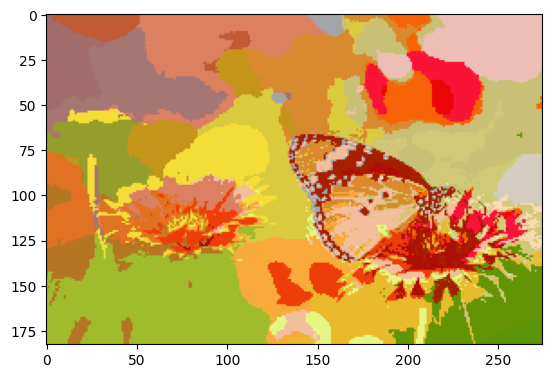

In [21]:
random_seeds = init_seed(X, 30)

###6 YOUR CODE HERE###
ms = MeanShift(bandwidth=2, seeds=random_seeds)
print(ms)
ms.fit(X)
#ms = ???
###END YOUR CODE###
center = ms.cluster_centers_
label = ms.labels_

print(len(center))

segmented_image = center[label]
segmented_image = segmented_image[:, :3]
segmented_image = np.reshape(segmented_image, img.shape)
plt.imshow(segmented_image/255.0)
plt.show()

#### Câu hỏi 3. Hãy thực hiện phân đoạn ảnh chụp Bách Khoa Hà Nội sau bằng thuật toán Meanshift và hiển thị kết quả phân đoạn ảnh

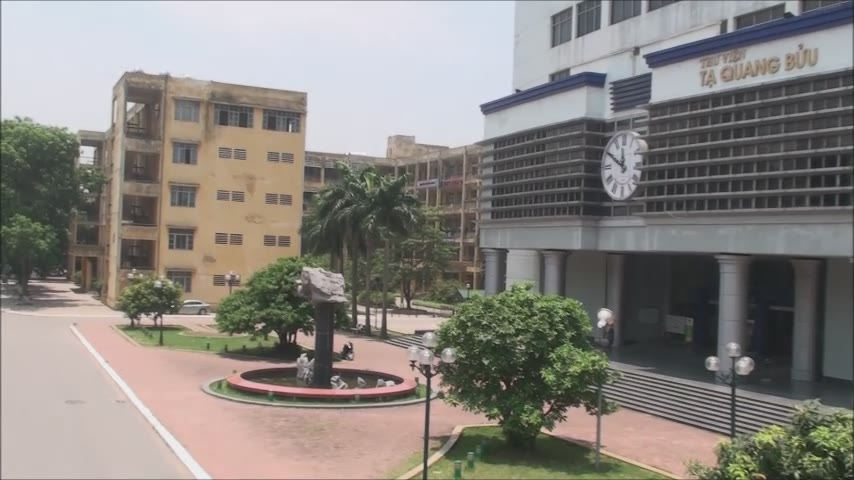

In [22]:
Image('./jupyter_img/bk.jpg')

MeanShift(bandwidth=2,
          seeds=array([[218., 224., 238.,  50., 467.],
       [136., 125., 124., 411., 652.],
       [138., 147., 105., 463., 451.],
       [ 96., 105.,  76., 465., 519.],
       [ 63.,  68.,  53., 381., 456.],
       [ 80.,  88.,  90., 374., 834.],
       [202., 191., 187., 432.,  67.],
       [ 52.,  58.,  45., 324., 270.],
       [ 73.,  85.,  61., 340., 443.],
       [197., 165., 154., 456., 327.]]))
10


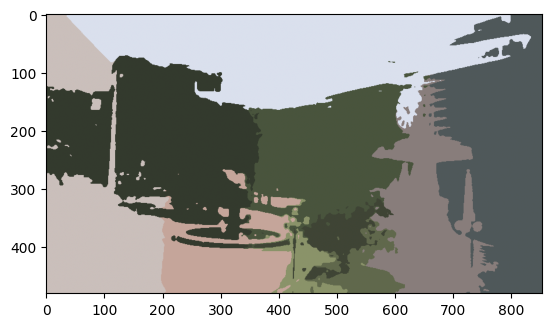

In [24]:
img = plt.imread('./jupyter_img/bk.jpg')
img = cv2.GaussianBlur(img, (9,9), 0)
X = get_5D_vector(img)
X.shape

random_seeds = init_seed(X, 10)

###7 YOUR CODE HERE###
ms = MeanShift(bandwidth=2, seeds=random_seeds)
print(ms)
ms.fit(X)
#ms = ???
###END YOUR CODE###

center = ms.cluster_centers_
label = ms.labels_

print(len(center))

segmented_image = center[label]
segmented_image = segmented_image[:, :3]
segmented_image = np.reshape(segmented_image, img.shape)
plt.imshow(segmented_image/255.0)
plt.show()

## II. Phân vùng ngữ nghĩa với mạng FCNs

### 1. Tìm hiểu bài toán và dữ liệu

Ta sẽ giải quyết bài toán Phân vùng ngữ nghĩa trên ảnh để tìm ra phần đường (road) trong một bức ảnh chụp quang cảnh đường phố từ phương tiện trong quá trình di chuyển (background sẽ là cây cối bên đường, nhà cửa, xe cộ, bầu trời,...)

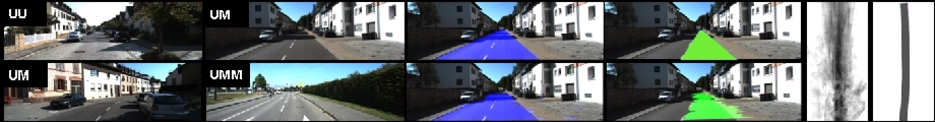

In [77]:
Image('./jupyter_img/kitti.jpg')

Bộ dữ liệu ta sẽ sử dụng là bộ KITTI ROAD (2013). Bộ dữ liệu gồm 289 ảnh training và 290 ảnh test. Bao gồm 3 loại ảnh đường phố sau:

- uu - urban unmarked (98 train/ 100 test): Đường không có vạch chia làn
- um - urban masked (95/96): Đường gồm 2 làn
- umm - urban multiple masked lanes (96/94): Đường gồm nhiều hơn 2 làn

Xem chi tiết tại: http://www.cvlibs.net/datasets/kitti/eval_road.php

Link tải training data: https://drive.google.com/open?id=14cEdEu3i5vc64Ps-Wq3y5ayOY32RIw2B
Link tải data (backup) dạng thư mục: https://drive.google.com/drive/folders/1BMPCc8ERVEHw5XkLwGFMYZs4yYSSLvmx

Ví dụ ảnh và "ground truth"
Lưu ý: Đường dẫn thư mục có thể phải thay đổi tùy thuộc vào cấu trúc thư mục (Colab) của sinh viên

In [ ]:
!unzip /content/gdrive/MyDrive/ComputerVision/CV10.SemanticSegmentation/data.zip -d /content/gdrive/MyDrive/ComputerVision/CV10.SemanticSegmentation

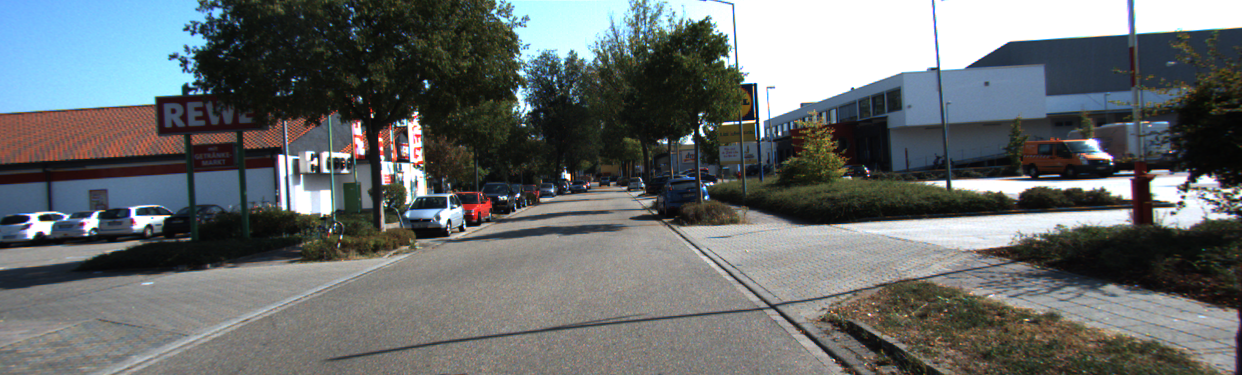

In [78]:
Image('./data/data_road/training/image_2/uu_000000.png')

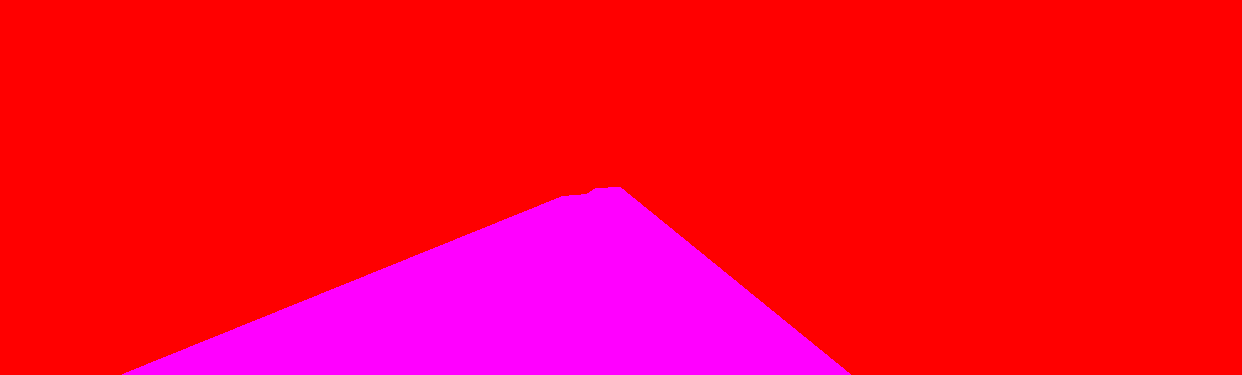

In [79]:
Image('./data/data_road/training/gt_image_2/uu_road_000000.png')

### 2. Kiểm tra GPU và version tensorflow để huấn luyện

In [142]:
# Check TensorFlow Version
from packaging import version
from distutils.version import LooseVersion
assert version.parse(tf.__version__) >= version.parse('1.0'), 'Please use TensorFlow version 1.0 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
  warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 2.15.0
Default GPU Device: /device:GPU:0


### 3.Nạp dữ liệu

#### 3.1. Dữ liệu nguồn

In [143]:
# Thư mục ảnh để huấn luyện/ thử nghiệm và thư mục ảnh "ground truth"
train_data_dir = "./data/data_road/training/image_2/"
train_gt_dir = "./data/data_road/training/gt_image_2/"

test_data_dir = "./data/data_road/testing/image_2/"

In [144]:
# Tỷ lệ huấn luyện và thử nghiệm
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
#TESTSET_SIZE = int(len(os.listdir(test_data_dir)))
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [145]:
# Thiết lập  tham số ban đầu
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

In [146]:
# Hàm để nạp ảnh bằng đường dẫn và trả về ảnh và "ground truth"
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Có 3 loại ảnh khác nhau: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])

    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [147]:
# Đọc toàn bộ ảnh trong thư mục train và chia thành từng bộ dữ liệu khác nhau
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)
print(TRAINSET_SIZE)
print(TESTSET_SIZE)
train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
#print(len(train_dataset))
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)

test_dataset = all_dataset.skip(TESTSET_SIZE)


231
30


### 3.2 Biến đổi ảnh

In [148]:
# Dùng Tensorflow để biến đổi khoảng sáng ảnh về khoảng [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Hàm Tensorflow để áp dụng biến đổi tiền xử lý ảnh train
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Hàm Tensorflow để áp dụng cho các ảnh test
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [171]:
BATCH_SIZE = 28
BUFFER_SIZE = 100

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


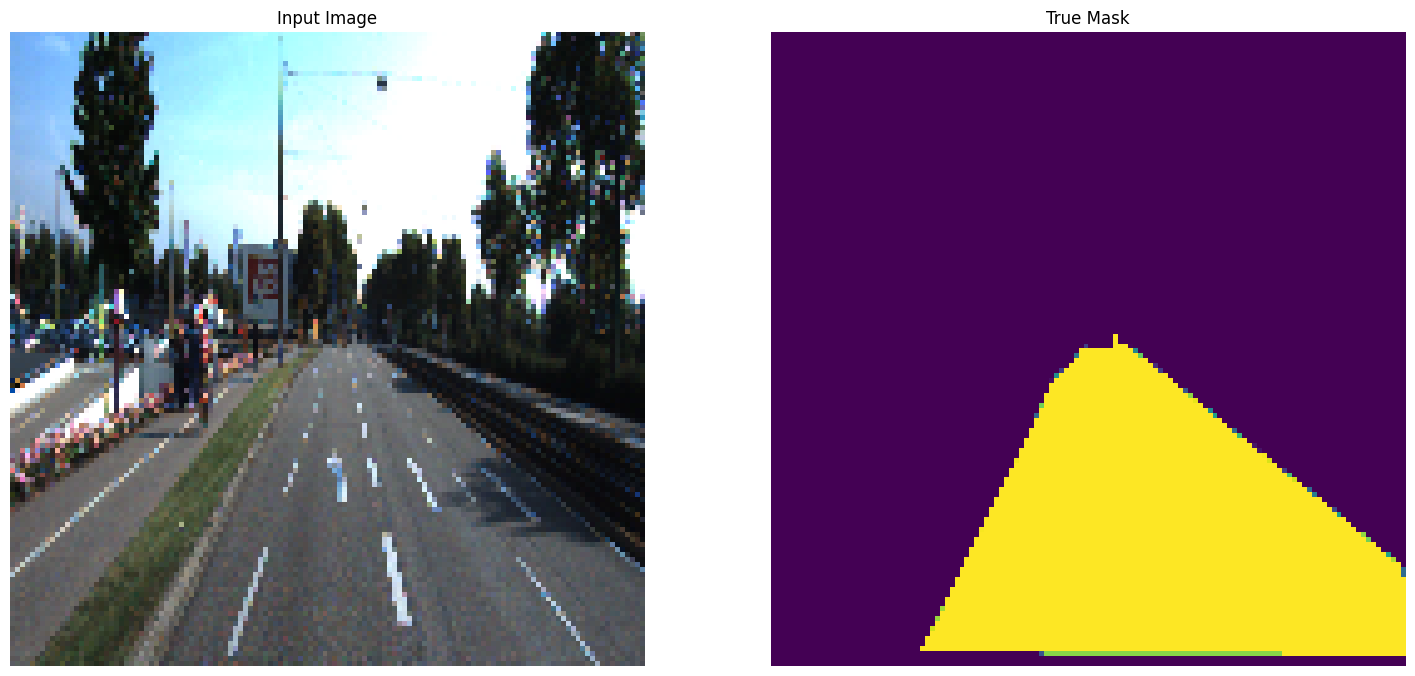

In [150]:
# Hàm để xem ảnh (mục đích hiển thị kết quả so sánh hoặc qua từng epoch)
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

#Hiển thị 1 ảnh mẫu và groundtruth
display_sample([sample_image[0], sample_mask[0]])

## 4. Tạo ra mạng (mô hình) tích chập - FCN_8

In [151]:
# Tải về mạng VGG-16 như là mạng backbone
vgg16_model = VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [152]:
# Định nghĩa kích thước đầu vào
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [153]:
# Tạo ra mô hình FCN 8 mới sử dụng mạng VGG16 n
# Đầu vào
inputs = Input(input_shape)

# Mạng VGG
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Những lớp Encoder
c1 = vgg16_model.get_layer("block3_pool").output
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output

# Những lớp Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Đầu ra
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

#Tạo thành mô hình
model = Model(inputs, outputs, name = "VGG_FCN8")

## 5. Huấn luyện

### 5.1 Hàm loss

In [154]:
m_iou = tf.keras.metrics.MeanIoU(2)
accuracy=tf.keras.metrics.Accuracy()
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss=BinaryCrossentropy(),
              metrics=[m_iou,accuracy])

### 5.2. Kiểm tra mô hình
Kiểm tra việc dự đoán và hiển thị mô hình (sử dụng các tham số gốc của VGG16)

1/1 [==============================] - 0s 161ms/step


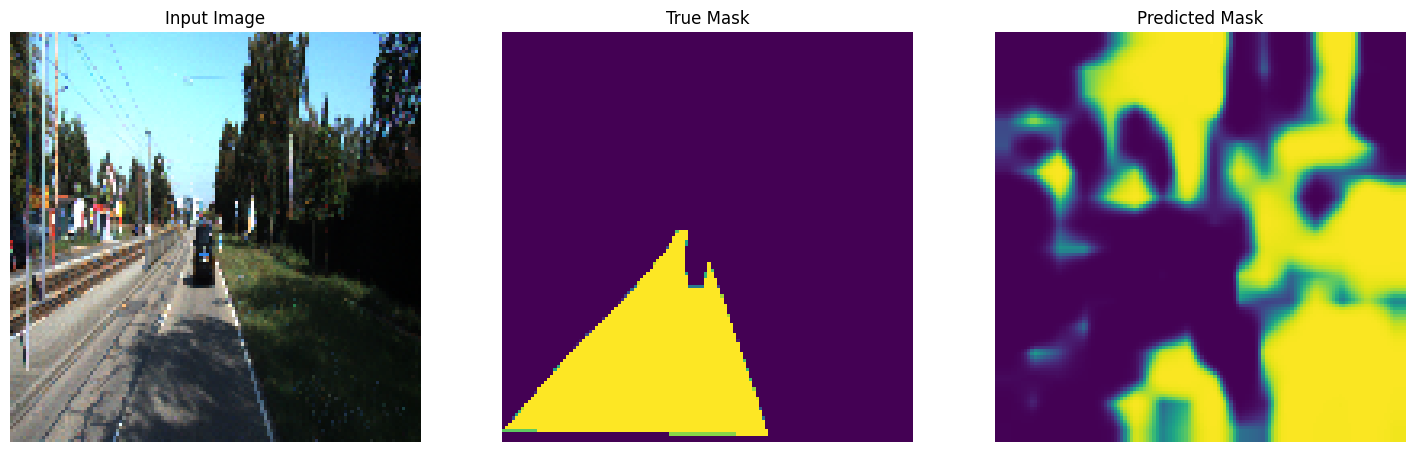

In [155]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)

    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

### 5.3. Huấn luyện mô hình
Thực hiện huấn luyện mô hình, với mỗi epoch hiển thị kết quả dự đoán tại thời điểm đấy với 1 ảnh mẫu trong CSDL. Có thể bỏ việc hiển thị "show_prediction" để tăng tốc thời gian thực hiện huấn luyện mô hình

In [172]:
from tensorflow.keras import callbacks
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        #show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]

# Set Variables
EPOCHS = 10
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE

VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE
print(VALIDSET_SIZE)
print(VALIDATION_STEPS)

28
1


In [173]:
model_history = model.fit(dataset['train'], epochs=200,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset['val'],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)



Sample Prediction after epoch 42


Epoch 42: val_loss did not improve from 0.05092
8/8 [==============================] - 14s 2s/step - loss: 0.0546 - mean_io_u_5: 0.4123 - accuracy: 4.0872e-06 - val_loss: 0.0604 - val_mean_io_u_5: 0.4206 - val_accuracy: 0.0000e+00
Epoch 42: early stopping


1/1 [==============================] - 0s 26ms/step


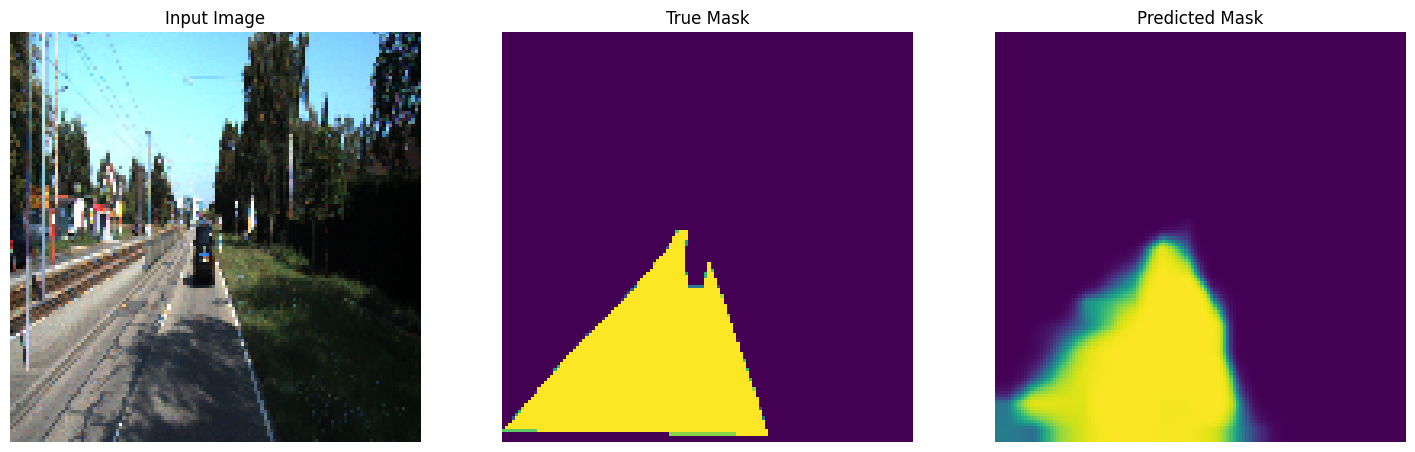

In [174]:
show_predictions()

In [175]:
model.save('./best_model.h5')
from IPython.display import FileLink
FileLink(r'best_model.h5')

/content/gdrive/MyDrive/ComputerVision/CV10.SemanticSegmentation/best_model.h5

In [176]:
from keras import models
model = models.load_model('./best_model.h5')

Vẽ ra các tham số loss và Mean IOU qua số epoch

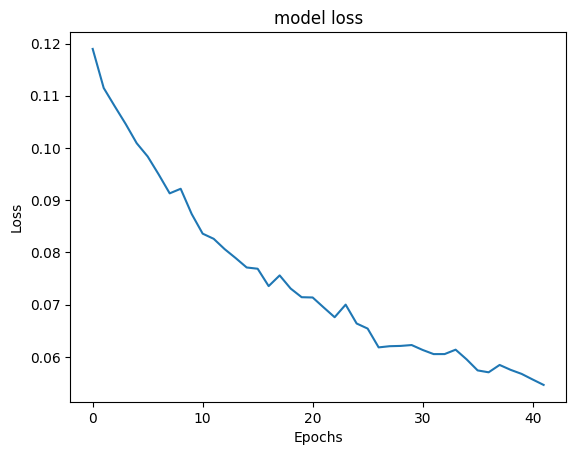

In [177]:
plt.plot(model_history.history['loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [179]:
print(model_history.history.keys())

dict_keys(['loss', 'mean_io_u_5', 'accuracy', 'val_loss', 'val_mean_io_u_5', 'val_accuracy'])


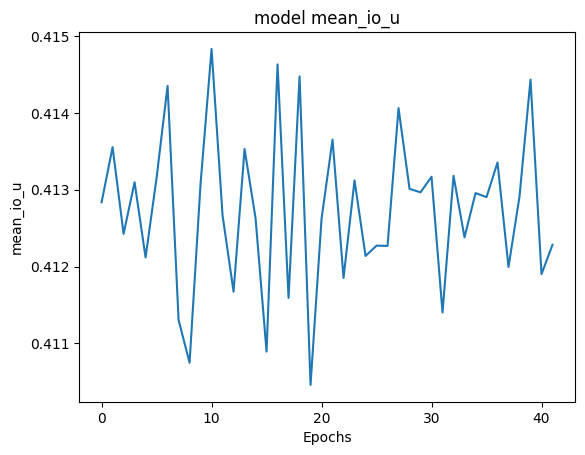

In [180]:
plt.plot(model_history.history['mean_io_u_5'])
plt.title("model mean_io_u")
plt.ylabel("mean_io_u")
plt.xlabel("Epochs")
plt.show()

## 6. Kiểm thử kết quả

In [181]:
# Hàm để tính toán mask trên ảnh
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Hàm để xử lý ảnh đơn lẻ
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)

    # Convert to image image
    image = np.asarray(image, np.float32)

    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [182]:
# Hàm lưu dự đoán
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Hàm lưu ảnh và vẽ
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.savefig(f"outputs/{index}.png")
    plt.show()

In [ ]:
os.makedirs("outputs", exist_ok=True)
print(dataset['test'])
print(test_dataset)
save_predictions(dataset['test'])

### 7. Bài tập thêm (tùy chọn)
Hãy thử thực hiện một số thao tác sau để xem kết quả sẽ thay đổi thế nào
- Thay số epoch từ 200 lên 2000
- Thay đổi hàm kích hoạt
- Thử bỏ đi các bước nối tắt
- Thay đổi learning rate